# Modern Time Series Analysis at SciPy 2019 by Aileen Nielsen

Seminar by Aileen Nielsen on some more advanced analysis techniques (Bayesian methods, machine learning, deep learning). Taking notes and trying out a few things. [Video](youtube.com/watch?v=v5ijNXvlC5A).



Common time series analysis tasks:

* Visualization and EDA including understanding trends, seasonality, stationarity, identifying underlying distributions and nature of temporal process producing data.
* Estimation of past, present future. 
* Classification.
* Anomaly detection.

Some characteristics that can complicate analysis:

* More likely to contain missing data than cross-sectional data (difficulty of collecting measurements over time).
* May have high degree of correlation between data points, which is good news for prediction tasks, but not so great for modeling tasks that need independent inputs to function well. 
* Time stamps introduce messiness in the form of time zones, frequency irregularities and so on.

A few more characteristics to bear in mind:

* Data is collected sequentially and one axis is increasing monotonically.
* Structure, such as seasonality, cycles, autocorrelation, trends, is characterized across data points.
* A single time series can display different behaviours over time and you need to be able to detect these shifts (e.g., change points and regime shifts versus drift and gradual change).

Something else to bear in mind, about an hour into the tutorial, Aileen seems to mention a pre-requisite for successful time series analysis: domain expertise.



## State space models for time series

### Box-Jenkins ARIMA models

Excellent performance on small data sets. Remains close to cutting edge performance. It imposes a high hurdle on modern techniques to overcome. [ARIMA on wikipedia](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) and [Box-Jenkins](https://en.wikipedia.org/wiki/Box%E2%80%93Jenkins_method). Box-Jenkins and ARIMA models are used to predict future values based on past values and errors.

Downsides:

* Not especially intuitive how it works.
* Some systems cycle more slowly or stochastically than can be easily described with an ARIMA model. 
* Performance flattens out on large dataset (good on tens of data points, less so on tens of thousands).

State space models offer their services in three stages:

![What state space models buy us](./images/state-space-models-uses.png)

Common techniques: Kalman Filter, local linear trend, smooth trend.

**Akaike Information Criterion (AIC)** is a measure used to evaluate state space models.

Coding along and exploring whatever seems interesting.

In [13]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = [14, 3]
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels

import scipy
from scipy.stats import pearsonr

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
print(matplotlib.__version__)
print(pd.__version__)
print(np.__version__)
print(statsmodels.__version__)
print(scipy.__version__)

3.1.1
0.25.3
1.18.1
0.10.1
1.3.1


In [3]:
df = pd.read_csv("data/global_temps.csv")
df.head(12)

,Source,Date,Mean
0,GCAG,2016-12-06,0.7895
1,GISTEMP,2016-12-06,0.8100
2,GCAG,2016-11-06,0.7504
3,GISTEMP,2016-11-06,0.9300
4,GCAG,2016-10-06,0.7292
5,GISTEMP,2016-10-06,0.8900
6,GCAG,2016-09-06,0.8767
7,GISTEMP,2016-09-06,0.8700
8,GCAG,2016-08-06,0.8998
9,GISTEMP,2016-08-06,0.9800


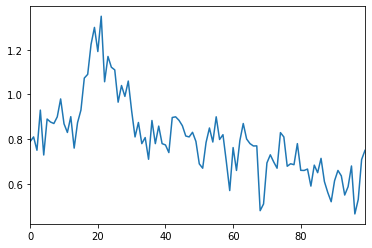

In [4]:
df.Mean[:100].plot()

There are two problems with this data set. One, we would like the x-axis to represent time and two, it looks like we are dealing with two time series signals here (i.e. `GCAG` and `GISTEMP`) and so ideally we want to be able to look at each separately.

In [5]:
df = df.pivot(index="Date", columns="Source", values="Mean")
df.head(12)

Source,GCAG,GISTEMP
Date,,
1880-01-06,0.0009,-0.30
1880-02-06,-0.1229,-0.21
1880-03-06,-0.1357,-0.18
1880-04-06,-0.0499,-0.27
1880-05-06,-0.0738,-0.14
1880-06-06,-0.1692,-0.29
1880-07-06,-0.1491,-0.24
1880-08-06,-0.0725,-0.08
1880-09-06,-0.0817,-0.17


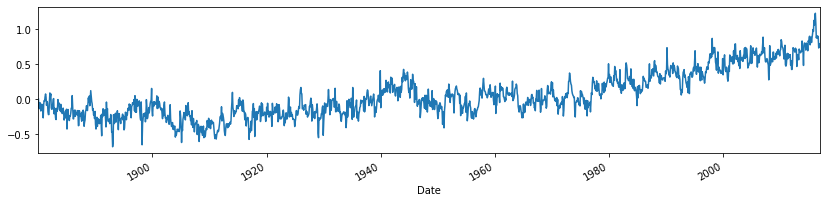

In [14]:
df["GCAG"].plot()

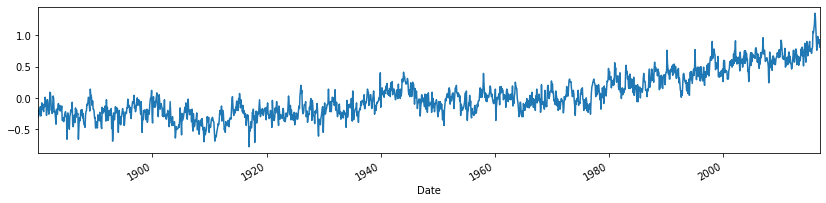

In [15]:
df["GISTEMP"].plot()

In [16]:
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

The index is not time-aware yet (just a bunch of numbers with hypens thrown in). We can convert these values to a proper `DatetimeIndex`.

In [17]:
df.index = pd.to_datetime(df.index)

In [18]:
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

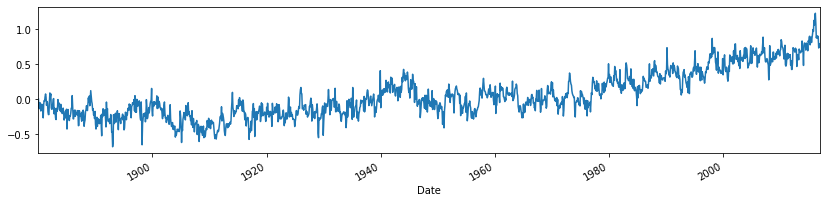

In [19]:
df.GCAG.plot()

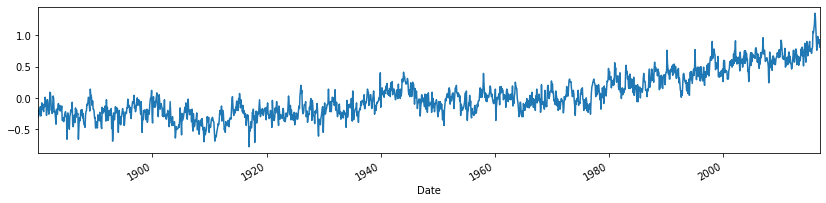

In [20]:
df.GISTEMP.plot()

Can index by year now.

In [21]:
df["1880"]

Source,GCAG,GISTEMP
Date,,
1880-01-06,0.0009,-0.30
1880-02-06,-0.1229,-0.21
1880-03-06,-0.1357,-0.18
1880-04-06,-0.0499,-0.27
1880-05-06,-0.0738,-0.14
1880-06-06,-0.1692,-0.29
1880-07-06,-0.1491,-0.24
1880-08-06,-0.0725,-0.08
1880-09-06,-0.0817,-0.17


Or do some basic computations on the index.

In [22]:
print(f"min: {df.index.min()}, max: {df.index.max()}")

min: 1880-01-06 00:00:00, max: 2016-12-06 00:00:00


Plot data for time ranges (for both time series).

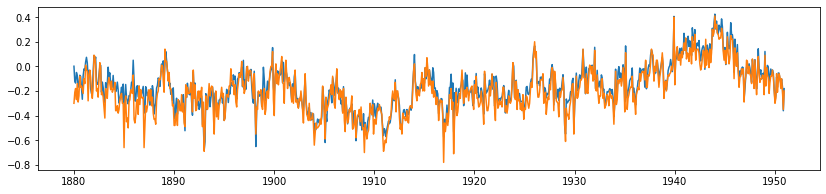

In [23]:
plt.plot(df["1880":"1950"][["GCAG", "GISTEMP"]])

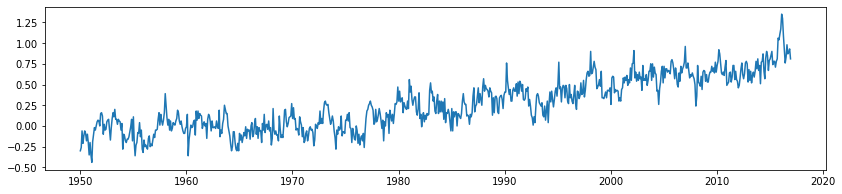

In [24]:
plt.plot(df["1950":]["GISTEMP"])

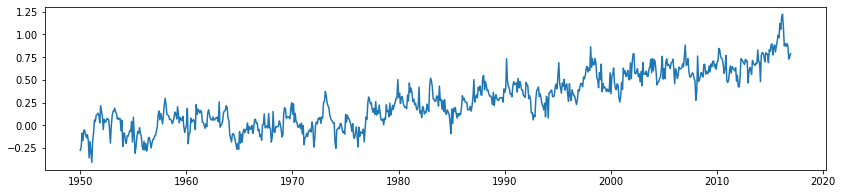

In [25]:
plt.plot(df["1950":]["GCAG"])

How strongly do these measurements correlated contemporaneously? 

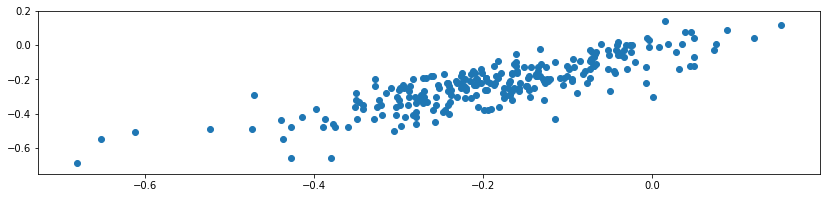

In [26]:
plt.scatter(df["1880":"1900"][["GCAG"]], df["1880":"1900"][["GISTEMP"]])

In [27]:
pearsonr(df["1880":"1900"].GCAG, df["1880":"1900"].GISTEMP)

(0.8373775278912143, 1.5894725243749507e-67)

What about if we add a time lag?

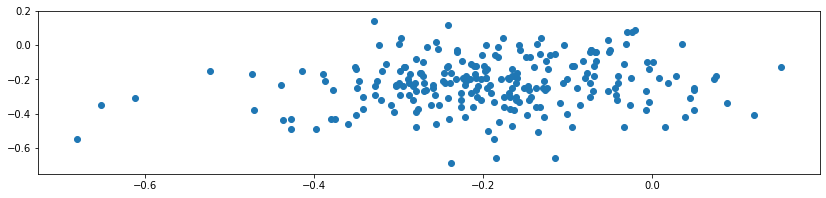

In [28]:
plt.scatter(df["1880":"1899"][["GCAG"]], df["1881":"1900"][["GISTEMP"]])

In [29]:
pearsonr(df["1880":"1899"].GCAG, df["1881":"1900"].GISTEMP)

(0.15464057329612763, 0.01650223473095511)

In [30]:
df["1880":"1899"].GCAG.head()

Date
1880-01-06    0.0009
1880-02-06   -0.1229
1880-03-06   -0.1357
1880-04-06   -0.0499
1880-05-06   -0.0738
Name: GCAG, dtype: float64

In [31]:
df["1881":"1900"].GISTEMP.head()

Date
1881-01-06   -0.10
1881-02-06   -0.14
1881-03-06    0.01
1881-04-06   -0.03
1881-05-06   -0.04
Name: GISTEMP, dtype: float64

### Unobserved components model

* Create a training set that consists of data from 1960 onward. 
* Define the parameters for a smooth trend model without cyclical or seasonal components.
* Fit an unobserved components model.


In [32]:
train = df["1960":]

In [33]:
model = { "level": "smooth trend", "cycle": False, "seasonal": None }

In [34]:
gcag_model = sm.tsa.UnobservedComponents(train["GCAG"], **model)
gcag_res = gcag_model.fit()

/Users/brunow/anaconda3/envs/py37scipy/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


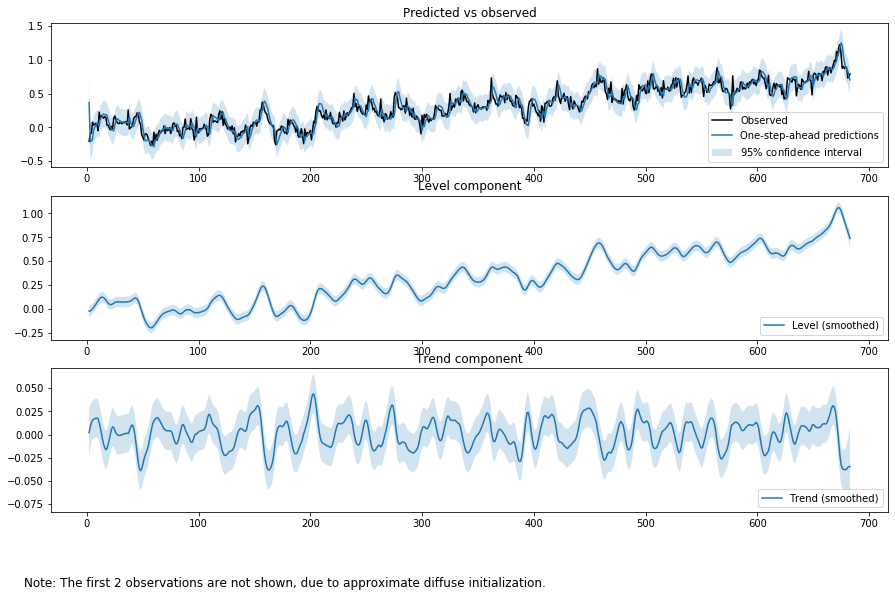

In [35]:
fig = gcag_res.plot_components(legend_loc="lower right", figsize=(15, 9))

Note that this is a one-step ahead prediction, so predicting temperaturees one month ahead.

Cannot really tell much from the trend graph. It does not look like there is a trend.

Predict 20 steps (months) ahead using the previous prediction as input for each subsequent prediction.

In [36]:
num_steps = 20
predict_res = gcag_res.get_prediction(dynamic=train["GCAG"].shape[0] - num_steps)

predict = predict_res.predicted_mean
ci = predict_res.conf_int()

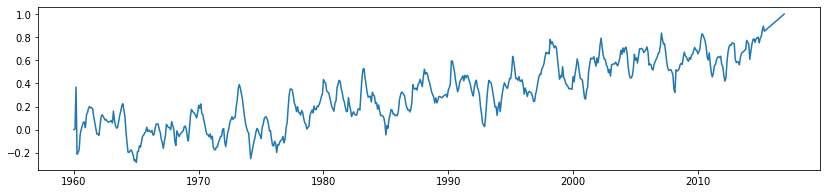

In [37]:
plt.plot(predict)

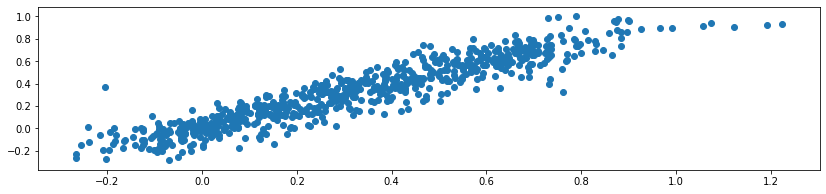

In [38]:
plt.scatter(train["GCAG"], predict)

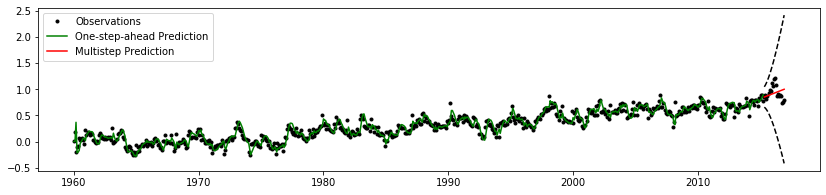

In [41]:
fig, ax = plt.subplots()
# Plot the results
ax.plot(train["GCAG"], "k.", label="Observations");
ax.plot(train.index[:-num_steps], predict[:-num_steps], "g", label="One-step-ahead Prediction");

ax.plot(train.index[-num_steps:], predict[-num_steps:], "r", label="Multistep Prediction");
ax.plot(train.index[-num_steps:], ci.iloc[-num_steps:], 'k--');

# Cleanup the image
legend = ax.legend(loc='upper left');

Zoom in a bit:

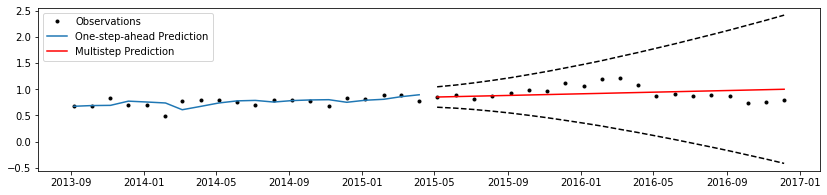

In [42]:

fig, ax = plt.subplots()
# Plot the results
ax.plot(train.index[-40:], train['GCAG'][-40:], 'k.', label='Observations');
ax.plot(train.index[-40:-num_steps], predict[-40:-num_steps], label='One-step-ahead Prediction');

ax.plot(train.index[-num_steps:], predict[-num_steps:], 'r', label='Multistep Prediction');
ax.plot(train.index[-num_steps:], ci.iloc[-num_steps:], 'k--');

# Cleanup the image
legend = ax.legend(loc='upper left');

You see that it makes its prediction for multiple time steps without taking error into consideration and adjusting accordingly. The multistep prediction goes off in a straight line. The further we go out into the future, the wider the bounds of the confidence interval become due to not incorporating the error into our prediction.

Next, we add a seasonal term for 12 periods to this model. We pick a seasonal term of 12 due to the data being monthly. A reasonable guess, I guess. Wondering if there is a more systematic approach to discover the seasonal term. Is that always a human decision or can this be automated and if so to what extent (i.e. what are the limitations)?

In [43]:
seasonal_model = {"level": "local linear trend", "seasonal": 12 }
mod = sm.tsa.UnobservedComponents(train["GCAG"], **seasonal_model)
res = mod.fit(method="powell", disp=False)

/Users/brunow/anaconda3/envs/py37scipy/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


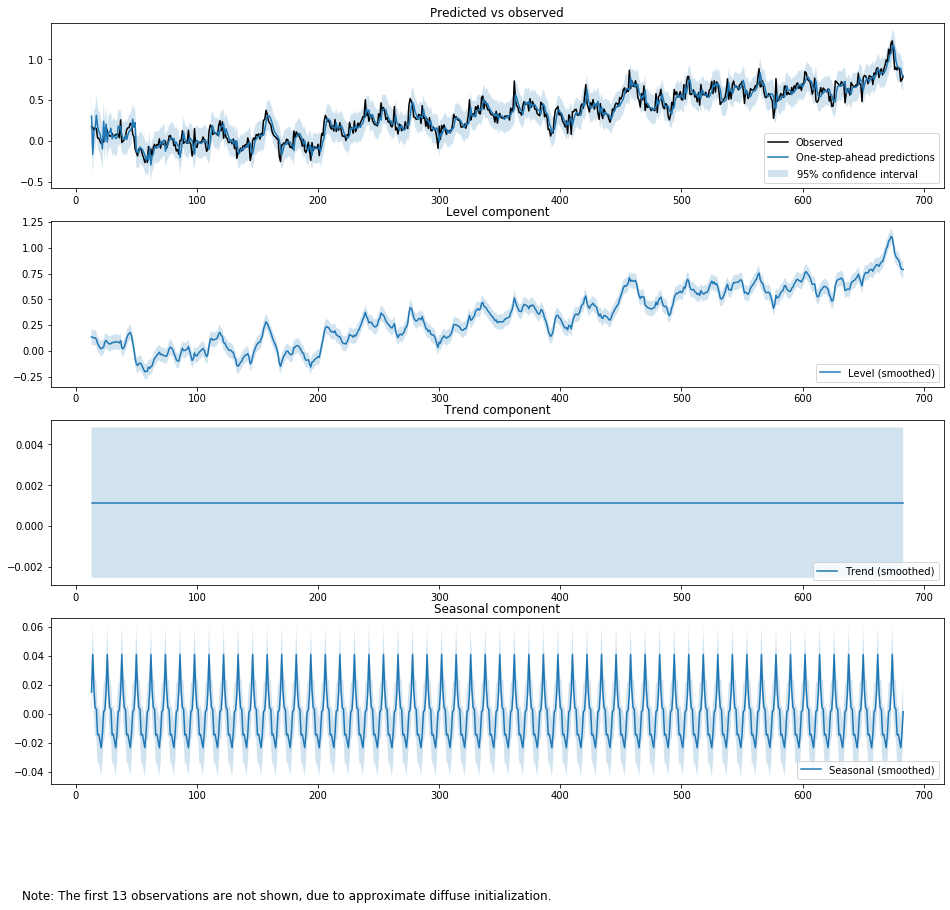

In [49]:
fig = res.plot_components(legend_loc="lower right", figsize=(16, 14))

We can compare how well these two models perform. First, we look at correlation between predictions and training data. Second, we look at the absolute error of both models.

In [51]:
pearsonr(gcag_res.predict(), train["GCAG"])

(0.9376554633519252, 3.16460221e-315)

In [52]:
pearsonr(res.predict(), train["GCAG"])

(0.9443196682706659, 0.0)

In [54]:
np.mean(np.abs(gcag_res.predict() - train["GCAG"]))

0.07721215185722816

In [55]:
np.mean(np.abs(res.predict() - train["GCAG"]))

0.07203435215679338

Correlation coefficient and mean absolute error do not indicate that there is a significant difference between the two models. So what is the effect of the seasonal term? 

The components plot above shows that the trend component has a very weak contribution to the signal (unlike the seasonal component). We can remove any consideration for trends from our model by using a so-called `local` level. The different trend components are documented [here](https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.structural.UnobservedComponents.html).

In [56]:
seasonal_model = { "level": "local level", "seasonal": 12 }
llmod = sm.tsa.UnobservedComponents(train["GCAG"], **seasonal_model)
ll_level_res = llmod.fit(method="powell", disp=False)


/Users/brunow/anaconda3/envs/py37scipy/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


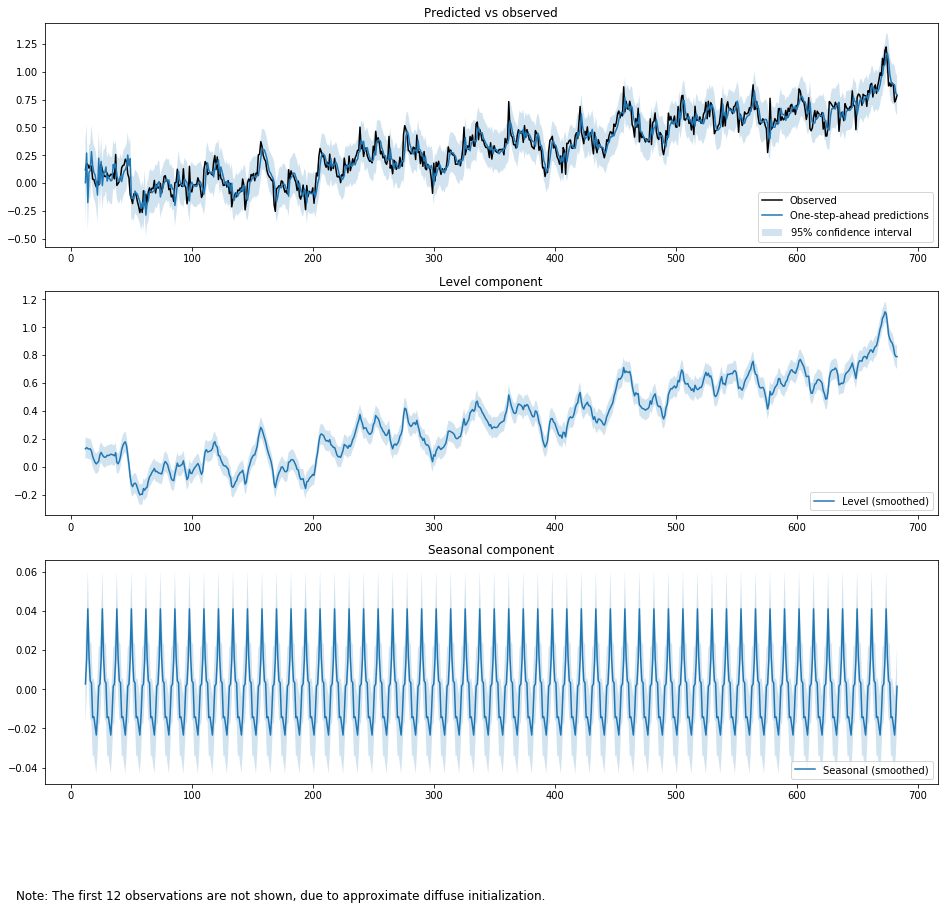

In [57]:
fig = ll_level_res.plot_components(legend_loc="lower right", figsize=(16, 14))

In [58]:
pearsonr(ll_level_res.predict(), train["GCAG"])

(0.9450048071803737, 0.0)

In [59]:
np.mean(np.abs(ll_level_res.predict() - train["GCAG"]))

0.07157737862671665

Even removing the trend component does not seem to make a big difference. Does it matter at all if we model seasonality and trends? Or is the devil in the detail (i.e. the small improvements lead to significantly higher accuracy in practice)?

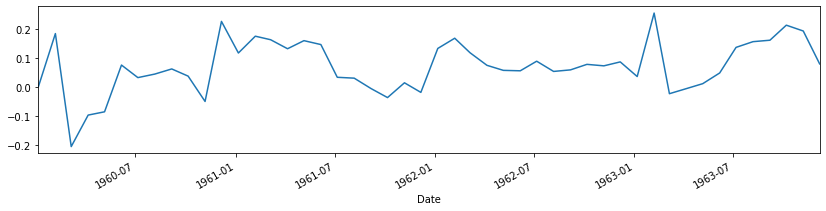

In [60]:
train[:48].GCAG.plot()

There is the concept of a `null model` for time series. A model that predicts the value at time $t - 1$ given the value at time $t$. We can look at correlation and mean absolute error for a null model and compare it with our best model so far.

In [61]:
pearsonr(ll_level_res.predict(), train["GCAG"])

(0.9450048071803737, 0.0)

In [62]:
pearsonr(train["GCAG"].iloc[:-1, ], train["GCAG"].iloc[1:, ])

(0.9403611903118239, 4.01e-321)

In [63]:
np.mean(np.abs(ll_level_res.predict() - train["GCAG"]))

0.07157737862671665

In [64]:
np.mean(np.abs(train["GCAG"].iloc[:-1, ].values, train["GCAG"].iloc[1:,  ].values))

0.3475446559297218

Not a big win compared with the null model in terms of correlation. When looking at mean absolute error, our model seems to perform better. How to interpret this depends on context/domain.

### Hidden Markov Models

[Wikipedia article](https://en.wikipedia.org/wiki/Hidden_Markov_model)

In a Markov process, the past does not matter if the present status is known. Using [Baum-Welch algorithm](https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm) for parameter estimation and the [Viterbi algorithm](https://en.wikipedia.org/wiki/Viterbi_algorithm) for smoothing / state labeling.

In [3]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = [10, 8]

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hmmlearn

from hmmlearn.hmm import GaussianHMM

In [4]:
print(matplotlib.__version__)
print(pd.__version__)
print(np.__version__)
print(hmmlearn.__version__)

3.1.1
0.25.3
1.18.1
0.2.4


In [5]:
nile = pd.read_csv("data/Nile.csv", index_col=0)

In [6]:
nile.head(10)

,year,val
1,1871,1120
2,1872,1160
3,1873,963
4,1874,1210
5,1875,1160
6,1876,1160
7,1877,813
8,1878,1230
9,1879,1370
10,1880,1140


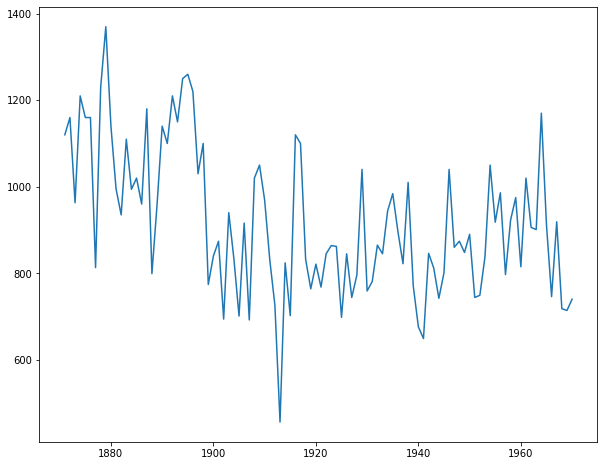

In [7]:
plt.plot(nile.year, nile.val)

In [57]:
# hmm expects two dimensions
vals = np.expand_dims(nile.val.values, 1)

# guessing that there are two states (high flow and low flow)
n_states = 2 

model = GaussianHMM(n_components=n_states, n_iter=100).fit(vals)
hidden_states = model.predict(vals)

In [58]:
print("Info about `hidden_states`\n")
print(f"{type(hidden_states)}")
print(f"{hidden_states.shape}")
print(f"sample: {hidden_states[:100:10]}")

Info about `hidden_states`

<class 'numpy.ndarray'>
(100,)
sample: [0 0 0 1 1 1 1 1 1 1]


In [59]:
# number of occurrence of each value
np.bincount(hidden_states)

array([28, 72])

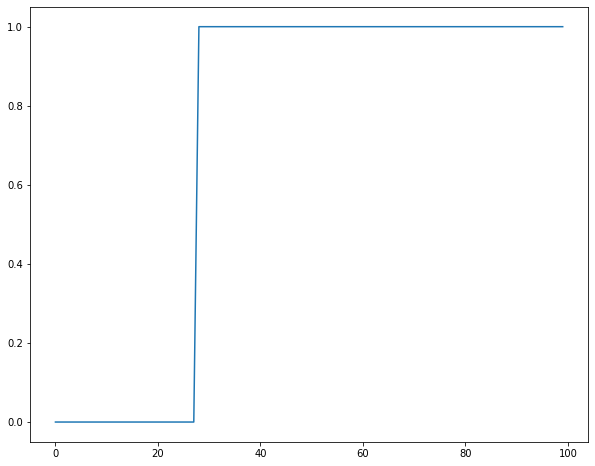

In [60]:
plt.plot(hidden_states)

All 1's for some time and then all 0's after that.

A more general method for fitting an HMM:

In [31]:
def fitHMM(vals, n_states, n_iter=100):
    vals = np.reshape(vals, [len(vals), 1])
    
    # fit Gaussian HMM to Q
    model = GaussianHMM(n_components=n_states, n_iter=n_iter).fit(vals)
     
    # classify each observation as state 0 or 1
    hidden_states = model.predict(vals)
 
    # fit HMM parameters
    mus = np.squeeze(model.means_)
    sigmas = np.squeeze(np.sqrt(model.covars_))
    transmat = np.array(model.transmat_)
    print(mus)
    print(sigmas)
    
#     # re-order parameters in ascending order of mean of underlying distribution
#     idx      = np.argsort(mus)
#     mus      = mus[idx]
#     sigmas   = sigmas[idx]
#     transmat = transmat[idx, :][:, idx]
    
#     state_dict = {}
#     states = [i for i in range(n_states)]
#     for i in idx:
#         state_dict[i] = states[idx[i]]
    
#     relabeled_states = [state_dict[h] for h in hidden_states]
    relabeled_states = hidden_states
    return (relabeled_states, mus, sigmas, transmat, model)

In [54]:
hidden_states, mus, sigmas, transmat, model = fitHMM(nile.val.values, 2)

[1097.15261711  850.75596948]
[133.74749638 124.44593534]


In [55]:
print("Info about `hidden_states`\n")
print(f"{type(hidden_states)}")
print(f"{hidden_states.shape}")
print(f"sample: {hidden_states[:100:10]}")

Info about `hidden_states`

<class 'numpy.ndarray'>
(100,)
sample: [0 0 0 1 1 1 1 1 1 1]


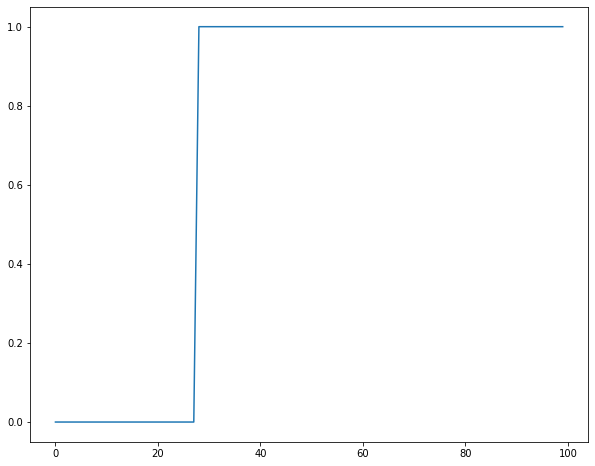

In [56]:
plt.plot(hidden_states)

In [46]:
hidden_states, mus, sigmas, transmat, model = fitHMM(nile.val.values, 2, 1000)

[1097.15261711  850.75596948]
[133.74749638 124.44593534]


In [47]:
print("Info about `hidden_states`\n")
print(f"{type(hidden_states)}")
print(f"{hidden_states.shape}")
print(f"sample: {hidden_states[:100:10]}")

Info about `hidden_states`

<class 'numpy.ndarray'>
(100,)
sample: [0 0 0 1 1 1 1 1 1 1]


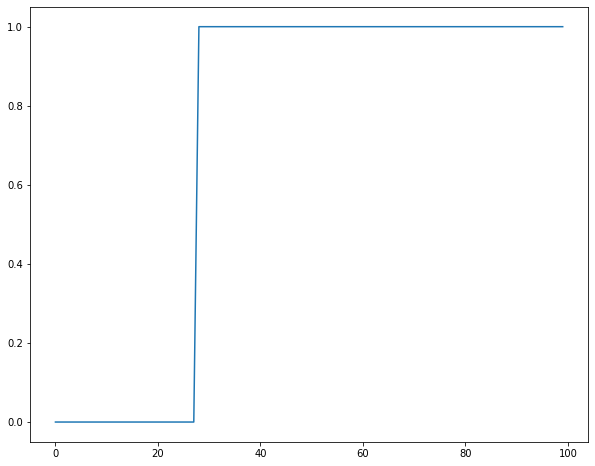

In [48]:
plt.plot(hidden_states)

In [61]:
hidden_states, mus, sigmas, transmat, model = fitHMM(nile.val.values, 2)

[1097.15261711  850.75596948]
[133.74749638 124.44593534]


Plotting the learned hidden states against the time series signal.

In [62]:

def plot_states(ts_vals, states, time_vals):
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Year)')
    ax1.set_ylabel('Nile river flow', color=color)
    ax1.plot(time_vals, ts_vals, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('Hidden state', color=color)  
    ax2.plot(time_vals, states, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  
    plt.show()

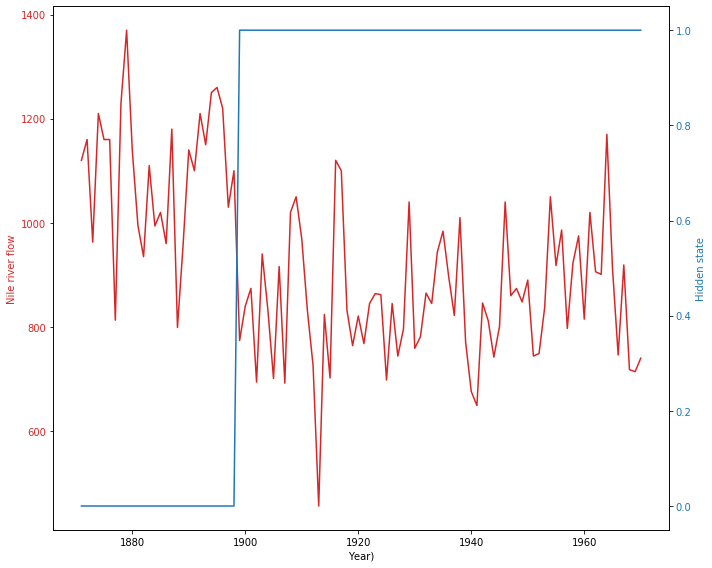

In [63]:
plot_states(nile.val, hidden_states, nile.year)

Next, we are experimenting (Aileen seems to imply 'improving', but I am not sure how we evaluate our models here) with slightly different ways of running this analysis. First, we remove the region where the hidden states are 0 and test the effect.

In [64]:
np.where(hidden_states == 0)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]),)

In [67]:
hidden_states, mus, sigmas, transmat, model = fitHMM(nile.val.values[28:], 2)

[792.26463809 937.46158761]
[ 95.06214029 110.56877622]


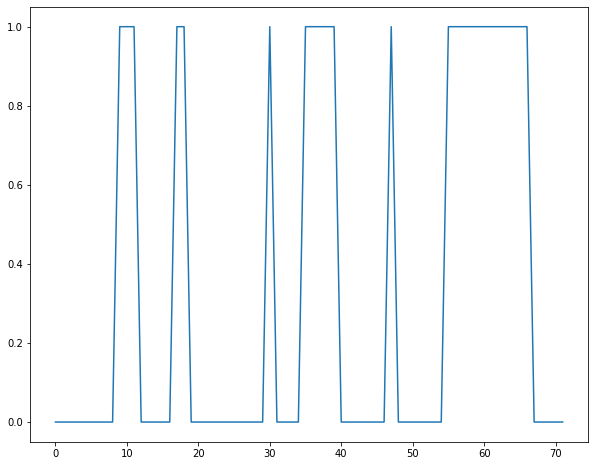

In [70]:
plt.plot(hidden_states)

We find more frequent regime shifts, but I do not know what to do with that. Cannot really evaluate, if this is 'better' or not.

We can also experiment with different numbers of states. Maybe there are more than just two states?

In [71]:
hidden_states, mus, sigmas, transmat, model = fitHMM(nile.val.values, 3)

[ 884.82315224  796.01723512 1097.27279934]
[138.785672    67.16297958 133.03503832]


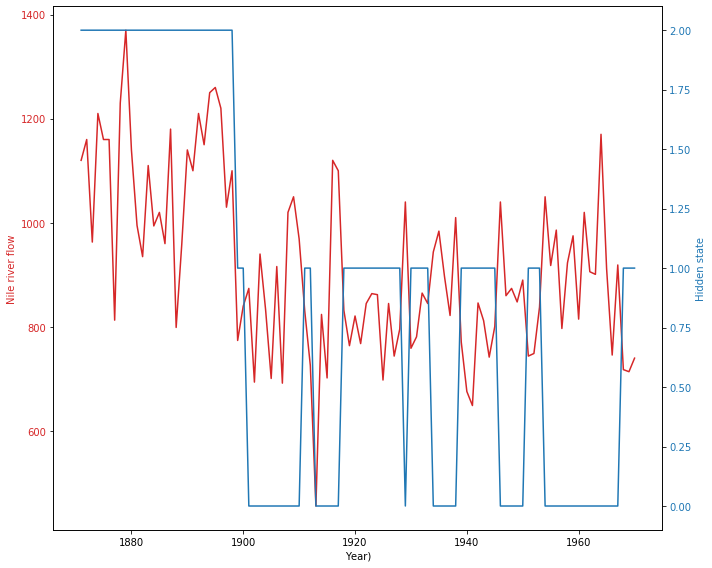

In [72]:
plot_states(nile.val, hidden_states, nile.year)

In [73]:
mus

array([ 884.82315224,  796.01723512, 1097.27279934])

In [76]:
# transition matrix of the probabilities of transitioning from any of the three states to any of the other three states
np.set_printoptions(precision=3, suppress=True)
transmat

array([[0.696, 0.304, 0.   ],
       [0.491, 0.509, 0.   ],
       [0.   , 0.036, 0.964]])

## Machine learning methods for time series

## Deep learning for time series 